## Install Lib

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install --upgrade --force-reinstall numpy catboost pandas scipy scikit-learn matplotlib seaborn

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 115.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 128.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

## Import Library

In [1]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import clone
from sklearn.model_selection import ParameterSampler

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score,
    GridSearchCV, RandomizedSearchCV, learning_curve
)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report, f1_score, auc, precision_recall_curve, average_precision_score
)
import joblib
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from IPython.display import display, HTML

warnings.filterwarnings('ignore', category=UserWarning)

## Variable

In [2]:
project_path = "/content/drive/MyDrive/Data_Analytics"
file_path = f"{project_path}/Dataset/dataset_cleaned_oversampling.csv"
result_path = f"{project_path}/Result/Oversampling"
hyper_path = f"{project_path}/Hyperparameter/Oversampling"
model_path = f"{project_path}/Models/Oversampling"

## Load Dataset

In [3]:
df = pd.read_csv(file_path)
print(df.shape)
print(df.info())

(21678, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21678 entries, 0 to 21677
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             21678 non-null  int64  
 1   Gender          21678 non-null  int64  
 2   BMI             21678 non-null  float64
 3   SBP             21678 non-null  float64
 4   DBP             21678 non-null  float64
 5   FPG             21678 non-null  float64
 6   Chol            21678 non-null  float64
 7   Tri             21678 non-null  float64
 8   HDL             21678 non-null  float64
 9   LDL             21678 non-null  float64
 10  ALT             21678 non-null  float64
 11  AST             21678 non-null  float64
 12  BUN             21678 non-null  float64
 13  CCR             21678 non-null  float64
 14  FFPG            21678 non-null  float64
 15  Smoking         21678 non-null  int64  
 16  Drinking        21678 non-null  int64  
 17  Family_history  216

In [4]:
df_train = df[df['dataset'] == 'train']
df_val = df[df['dataset'] == 'validation']
df_test = df[df['dataset'] == 'test']

X_train = df_train.drop(columns=['Diabetes', 'dataset'])
y_train = df_train['Diabetes']

X_val = df_val.drop(columns=['Diabetes', 'dataset'])
y_val = df_val['Diabetes']

X_test = df_test.drop(columns=['Diabetes', 'dataset'])
y_test = df_test['Diabetes']

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (17530, 18)
Validation shape: (2765, 18)
Test shape: (1383, 18)


In [5]:
numeric_features_to_scale = [
    'Age', 'BMI', 'SBP', 'DBP', 'FPG', 'Chol', 'Tri', 'HDL', 'LDL',
    'ALT', 'AST', 'BUN', 'CCR', 'FFPG'
]
categorical_features = ['Gender', 'Smoking', 'Drinking', 'Family_history']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features_to_scale)
    ],
    remainder='passthrough'
)

scaled_x_train = preprocessor.fit_transform(X_train)
scaled_x_val = preprocessor.transform(X_val)
scaled_x_test = preprocessor.transform(X_test)
os.makedirs(model_path, exist_ok=True)
joblib.dump(preprocessor, f"{model_path}/scaler.joblib")

['/content/drive/MyDrive/Data_Analytics/Models/Oversampling/scaler.joblib']

## HyperParameter Tuning

In [6]:
hyper_file = f"{hyper_path}/parameter.json"
os.makedirs(hyper_path, exist_ok=True)

param_grids = {
    "Random Forest": {
        'n_estimators': [100, 200, 300],
        'max_depth': [8, 12, 16, 20],
        'min_samples_split': [10, 20, 40],
        'min_samples_leaf': [5, 10, 15],
        'max_features': ['sqrt', 0.7, 0.8],
        'ccp_alpha': [0, 0.001, 0.005]
    },
    "Decision Tree": {
        'max_depth': [5, 8, 10, 15],
        'min_samples_split': [20, 40, 60],
        'min_samples_leaf': [10, 15, 20],
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0, 0.005, 0.01, 0.02]
    },
    "XGBoost": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'gamma': [0.1, 0.5, 1, 2],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 3, 5, 10]
    },
    "Gradient Boosting": {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 0.9],
        'min_samples_split': [10, 20, 40],
        'min_samples_leaf': [5, 10, 15],
        'max_features': ['sqrt', 'log2', 0.8]
    },
    "CatBoost": {
        'iterations': [100, 200, 300, 400],
        'learning_rate': [0.03, 0.05, 0.1],
        'depth': [4, 5, 6, 7],
        'l2_leaf_reg': [5, 10, 15, 20],
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bylevel': [0.7, 0.8, 0.9],
        'border_count': [32, 64]
    }
}

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

def tune_model_with_validation(name, model, param_grid, X_train, y_train, X_val, y_val, metric='accuracy', n_iter=20):
    print(f"=== Hyperparameter Tuning {name} ===\n")

    if not param_grid:
        print(f"{name} dilatih dengan parameter default.")
        model.fit(X_train, y_train)

        # Evaluasi pada validation set
        y_pred = model.predict(X_val)
        if metric == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif metric == 'f1':
            score = f1_score(y_val, y_pred, average='weighted')
        elif metric == 'auc':
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_val)
                if len(np.unique(y_val)) > 2:  # multiclass
                    score = roc_auc_score(y_val, y_proba, multi_class='ovr')
                else:  # binary
                    score = roc_auc_score(y_val, y_proba[:, 1])
            else:
                score = accuracy_score(y_val, y_pred)
                print(f"Model tidak mendukung predict_proba, menggunakan accuracy.")

        print(f"Skor {metric} untuk {name} dengan parameter default: {score:.4f}")
        return model, model.get_params(), score


    # Generate parameter combinations untuk random search
    param_combinations = list(ParameterSampler(
        param_grid, n_iter=n_iter, random_state=42
    ))

    print(f"Menguji {len(param_combinations)} kombinasi parameter...")

    best_score = -np.inf
    best_params = None
    best_model = None

    for i, params in enumerate(param_combinations):
        try:
            model_instance = clone(model)
            model_instance.set_params(**params)

            model_instance.fit(X_train, y_train)

            y_pred = model_instance.predict(X_val)

            if metric == 'accuracy':
                score = accuracy_score(y_val, y_pred)
            elif metric == 'f1':
                score = f1_score(y_val, y_pred, average='weighted')
            elif metric == 'auc':
                if hasattr(model_instance, "predict_proba"):
                    y_proba = model_instance.predict_proba(X_val)
                    if len(np.unique(y_val)) > 2:  # multiclass
                        score = roc_auc_score(y_val, y_proba, multi_class='ovr')
                    else:  # binary
                        score = roc_auc_score(y_val, y_proba[:, 1])
                else:
                    score = accuracy_score(y_val, y_pred)
                    if i == 0:
                        print(f"Model tidak mendukung predict_proba, menggunakan accuracy.")

            if score > best_score:
                best_score = score
                best_params = params
                best_model = model_instance

            if (i + 1) % max(1, len(param_combinations) // 10) == 0:
                print(f"  Progress: {i+1}/{len(param_combinations)} kombinasi selesai. Best {metric} so far: {best_score:.4f}")

        except Exception as e:
            print(f"  Error dengan parameter {params}: {str(e)}")
            continue

    if best_model is None:
        print(f"Semua kombinasi parameter gagal. Menggunakan parameter default.")
        model.fit(X_train, y_train)
        return model, model.get_params(), -np.inf

    print(f"\nBest {metric} for {name} pada validation set: {best_score:.4f}")
    print("Parameter terbaik:", best_params)

    return best_model, best_params, best_score

def clean_params_for_json(params):
    cleaned = {}
    for key, value in params.items():
        if isinstance(value, (int, float, str, bool, list, dict)) or value is None:
            cleaned[key] = value
        else:
            pass
    return cleaned

best_models = {}
metrics = {}

if os.path.exists(hyper_file):
    try:
        with open(hyper_file, "r") as f:
            best_models_params_loaded = json.load(f)
        print(f"Loaded best hyperparameters from {hyper_file}")

        for name in models:
            if name in best_models_params_loaded:
                print(f"Loading and fitting model: {name}")
                model_instance = models[name]
                valid_param_keys = model_instance.get_params().keys()
                params_to_set = {k: v for k, v in best_models_params_loaded[name].items() if k in valid_param_keys}

                try:
                    model_instance.set_params(**params_to_set)
                except ValueError as e:
                     print(f"Warning: Could not set some params for {name}: {e}")
                     print(f"Attempting with params: {params_to_set}")

                model_instance.fit(scaled_x_train, y_train)
                best_models[name] = model_instance

                val_acc = accuracy_score(y_val, model_instance.predict(scaled_x_val))
                metrics[name] = {'validation_accuracy': val_acc}
                print(f"  Validation accuracy for {name}: {val_acc:.4f}")
            else:
                print(f"Warning: No parameters found for {name} in {hyper_file}. Skipping loading, will train with defaults if needed later.")

        print("Finished loading and fitting models from parameters.")

    except json.JSONDecodeError:
        print(f"Error reading {hyper_file}. File might be corrupted. Starting tuning...")
        os.remove(hyper_file) # Hapus file yang rusak agar bisa dibuat ulang
    except Exception as e:
        print(f"An unexpected error occurred while loading parameters: {e}. Starting tuning...")

if not os.path.exists(hyper_file):
    print("\nStarting hyperparameter tuning process with validation set...")
    best_models_params_to_save = {}
    metrics = {}

    for name in models:
        print(f"\nTuning {name}...")
        tuned_model, best_params, val_score = tune_model_with_validation(
            name=name,
            model=models[name],
            param_grid=param_grids.get(name, {}),
            X_train=scaled_x_train,
            y_train=y_train,
            X_val=scaled_x_val,
            y_val=y_val,
            metric='accuracy',  # Bisa diganti dengan 'f1' atau 'auc'
            n_iter=20
        )

        best_models[name] = tuned_model
        best_models_params_to_save[name] = best_params
        metrics[name] = {'validation_accuracy': val_score}

    cleaned_best_models_params = {
        name: clean_params_for_json(params)
        for name, params in best_models_params_to_save.items()
    }

    try:
        with open(hyper_file, "w") as f:
            json.dump(cleaned_best_models_params, f, indent=4)
        print(f"\nBest hyperparameters saved to {hyper_file}")

        metrics_file = f"{hyper_path}/validation_metrics.json"
        with open(metrics_file, "w") as f:
            json.dump(metrics, f, indent=4)
        print(f"Validation metrics saved to {metrics_file}")
    except Exception as e:
        print(f"\nError saving hyperparameters to {hyper_file}: {e}")

    print("Finished tuning models.")

print("\nValidation Performance Summary:")
for name, metric_values in metrics.items():
    print(f"{name}: Accuracy = {metric_values.get('validation_accuracy', 'N/A'):.4f}")

print("\nSaving trained models to .pkl files...")
for name, model in best_models.items():
    model_filename = os.path.join(model_path, f"{name}.pkl")
    try:
        joblib.dump(model, model_filename)
        print(f"Model '{name}' saved successfully to {model_filename}")
    except Exception as e:
        print(f"Error saving model '{name}' to {model_filename}: {e}")
print("Finished saving models.")


Starting hyperparameter tuning process with validation set...

Tuning Random Forest...
=== Hyperparameter Tuning Random Forest ===

Menguji 20 kombinasi parameter...
  Progress: 2/20 kombinasi selesai. Best accuracy so far: 0.9363
  Progress: 4/20 kombinasi selesai. Best accuracy so far: 0.9363
  Progress: 6/20 kombinasi selesai. Best accuracy so far: 0.9363
  Progress: 8/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 10/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 12/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 14/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 16/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 18/20 kombinasi selesai. Best accuracy so far: 0.9396
  Progress: 20/20 kombinasi selesai. Best accuracy so far: 0.9396

Best accuracy for Random Forest pada validation set: 0.9396
Parameter terbaik: {'n_estimators': 200, 'min_samples_split': 40, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_d

## ModelEvaluator Class

In [7]:
class ModelEvaluator:
    def __init__(self, project_path, scaling_data, best_models, y_data):
        self.project_path = project_path
        self.scaled_x_train, self.scaled_x_val, self.scaled_x_test = scaling_data
        self.best_models = best_models
        self.y_train, self.y_val, self.y_test = y_data
        self.roc_data = {}
        self.pr_data = {}

    def evaluate(self, model_name):
        model = self.best_models.get(model_name)
        if model is None:
            print(f"❌ Model {model_name} tidak ditemukan!")
            return

        result_save = f"{result_path}/{model_name}/"
        os.makedirs(result_save, exist_ok=True)

        y_pred_val = model.predict(self.scaled_x_val)
        acc_val = model.score(self.scaled_x_val, self.y_val)

        report_val = classification_report(self.y_val, y_pred_val, output_dict=True)
        f1_val = report_val["weighted avg"]["f1-score"]

        cm_val = confusion_matrix(self.y_val, y_pred_val)

        y_pred_test = model.predict(self.scaled_x_test)
        acc_test = model.score(self.scaled_x_test, self.y_test)

        report_test = classification_report(self.y_test, y_pred_test, output_dict=True)
        f1_test = report_test["weighted avg"]["f1-score"]

        cm_test = confusion_matrix(self.y_test, y_pred_test)

        if hasattr(model, "predict_proba"):
            y_proba_val = model.predict_proba(self.scaled_x_val)[:, 1]
            y_proba_test = model.predict_proba(self.scaled_x_test)[:, 1]

            # ROC Curve
            fpr_val, tpr_val, _ = roc_curve(self.y_val, y_proba_val)
            auc_val = auc(fpr_val, tpr_val)

            fpr_test, tpr_test, _ = roc_curve(self.y_test, y_proba_test)
            auc_test = auc(fpr_test, tpr_test)

            self.roc_data[model_name] = {
                "fpr_test": fpr_test,
                "tpr_test": tpr_test,
                "auc_test": auc_test,
                "fpr_val": fpr_val,
                "tpr_val": tpr_val,
                "auc_val": auc_val
            }

            precision_val, recall_val, _ = precision_recall_curve(self.y_val, y_proba_val)
            ap_val = average_precision_score(self.y_val, y_proba_val)

            precision_test, recall_test, _ = precision_recall_curve(self.y_test, y_proba_test)
            ap_test = average_precision_score(self.y_test, y_proba_test)

            self.pr_data[model_name] = {
                "precision_val": precision_val,
                "recall_val": recall_val,
                "ap_val": ap_val,
                "precision_test": precision_test,
                "recall_test": recall_test,
                "ap_test": ap_test
            }
        else:
            auc_val, auc_test = None, None
            ap_val, ap_test = None, None

        print("\n=== Training Set ===")
        print("\n📊 Training Evaluation Results :")
        train_final, val_final, _ = self._plot_learning_curve(model, model_name, result_save)

        evaluation_results = {
            "Accuracy (Training)": round(train_final, 3),
            "Accuracy (Validation)": round(acc_val, 3),
            "F1-Score (Validation)": round(f1_val, 3),
            "Accuracy (Test)": round(acc_test, 3),
            "F1-Score (Test)": round(f1_test, 3),
            "AUC (Validation)": round(auc_val, 3) if auc_val is not None else "N/A",
            "AUC (Test)": round(auc_test, 3) if auc_test is not None else "N/A",
            "AP (Validation)": round(ap_val, 3) if ap_val is not None else "N/A",
            "AP (Test)": round(ap_test, 3) if ap_test is not None else "N/A",
        }

        with open(os.path.join(result_save, f"{model_name}_evaluation.json"), "w") as json_file:
            json.dump(evaluation_results, json_file, indent=4)


        print("\n=== Validation Set ===")
        print("\n📊 Validation Evaluation Results :")
        print(f"Accuracy (Validation): {round(acc_val, 3)}")
        print(f"F1-Score (Validation): {round(f1_val, 3)}")
        print(f"AUC (Validation): {round(auc_val, 3) if auc_val is not None else 'N/A'}")
        print(f"AP (Validation): {round(ap_val, 3) if ap_val is not None else 'N/A'}")

        print("\n📄 Classification Report (Validation):")
        print(classification_report(self.y_val, y_pred_val))

        self._save_and_show_confusion_matrix(cm_val, result_save, f"{model_name}_Confusion_Matrix_Validation.png", f"Confusion Matrix - {model_name} (Validation)")

        if auc_val is not None:
            self._plot_roc_curve(fpr_val, tpr_val, auc_val, result_save, f"{model_name}_ROC_Curve_Validation.png", f"ROC Curve - {model_name} (Validation)")

        if ap_val is not None:
            self._plot_pr_curve(precision_val, recall_val, ap_val, result_save, f"{model_name}_PR_Curve_Validation.png", f"Precision-Recall Curve - {model_name} (Validation)")

        print("\n=== Test Set ===")
        print("\n📊 Test Evaluation Results :")
        print(f"Accuracy (Test): {round(acc_test, 3)}")
        print(f"F1-Score (Test): {round(f1_test, 3)}")
        print(f"AUC (Test): {round(auc_test, 3) if auc_test is not None else 'N/A'}")
        print(f"AP (Test): {round(ap_test, 3) if ap_test is not None else 'N/A'}")

        print("\n📄 Classification Report (Test):")
        print(classification_report(self.y_test, y_pred_test))

        self._save_and_show_confusion_matrix(cm_test, result_save, f"{model_name}_Confusion_Matrix_Test.png", f"Confusion Matrix - {model_name} (Test)")

        if auc_test is not None:
            self._plot_roc_curve(fpr_test, tpr_test, auc_test, result_save, f"{model_name}_ROC_Curve_Test.png", f"ROC Curve - {model_name} (Test)")

        if ap_test is not None:
            self._plot_pr_curve(precision_test, recall_test, ap_test, result_save, f"{model_name}_PR_Curve_Test.png", f"Precision-Recall Curve - {model_name} (Test)")

        print(f"\n✅ Hasil evaluasi {model_name} disimpan di {result_save}")

    def _save_and_show_confusion_matrix(self, cm, path, filename, title):
        os.makedirs(path, exist_ok=True)
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=0.5)
        plt.title(title)
        plt.tight_layout()
        plt.savefig(os.path.join(path, filename), dpi=300)
        plt.show()
        plt.close()

    def _plot_roc_curve(self, fpr, tpr, auc_score, path, filename, title):
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', color='blue')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.savefig(os.path.join(path, filename), dpi=300)
        plt.show()
        plt.close()

    def _plot_pr_curve(self, precision, recall, ap_score, path, filename, title):
        plt.figure(figsize=(6, 5))
        plt.plot(recall, precision, label=f'PR Curve (AP = {ap_score:.3f})', color='green')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(title)
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.savefig(os.path.join(path, filename), dpi=300)
        plt.show()
        plt.close()

    def plot_roc_side_by_side(self):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        for model_name, data in self.roc_data.items():
            fpr_val, tpr_val, auc_val = data["fpr_val"], data["tpr_val"], data["auc_val"]
            axes[0].plot(fpr_val, tpr_val, label=f"{model_name} (AUC={auc_val:.3f})")

            fpr_test, tpr_test, auc_test = data["fpr_test"], data["tpr_test"], data["auc_test"]
            axes[1].plot(fpr_test, tpr_test, label=f"{model_name} (AUC={auc_test:.3f})")

        axes[0].plot([0, 1], [0, 1], "k--")
        axes[0].set_title("ROC Curve - Validation Set")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")
        axes[0].legend(loc="lower right")
        axes[0].grid(True)

        axes[1].plot([0, 1], [0, 1], "k--")
        axes[1].set_title("ROC Curve - Test Set")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend(loc="lower right")
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(result_path, "ROC_Curves_Comparison.png"), dpi=300)
        plt.show()
        plt.close()

    def plot_pr_side_by_side(self):
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))

        for model_name, data in self.pr_data.items():
            recall_val, precision_val, ap_val = data["recall_val"], data["precision_val"], data["ap_val"]
            axes[0].plot(recall_val, precision_val, label=f"{model_name} (AP={ap_val:.3f})")

            recall_test, precision_test, ap_test = data["recall_test"], data["precision_test"], data["ap_test"]
            axes[1].plot(recall_test, precision_test, label=f"{model_name} (AP={ap_test:.3f})")

        axes[0].set_title("Precision-Recall Curve - Validation Set")
        axes[0].set_xlabel("Recall")
        axes[0].set_ylabel("Precision")
        axes[0].legend(loc="lower left")
        axes[0].grid(True)

        axes[1].set_title("Precision-Recall Curve - Test Set")
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
        axes[1].legend(loc="lower left")
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig(os.path.join(result_path, "PR_Curves_Comparison.png"), dpi=300)
        plt.show()
        plt.close()

    def _plot_learning_curve(self, model, model_name, path):
        train_sizes = np.linspace(0.1, 1.0, 10)

        train_scores = []
        val_scores = []

        for size in train_sizes:
            n_samples = int(size * len(self.scaled_x_train))
            model_clone = clone(model)
            model_clone.fit(self.scaled_x_train[:n_samples], self.y_train[:n_samples])
            train_score = accuracy_score(self.y_train[:n_samples],
                                          model_clone.predict(self.scaled_x_train[:n_samples]))
            val_score = accuracy_score(self.y_val, model_clone.predict(self.scaled_x_val))

            train_scores.append(train_score)
            val_scores.append(val_score)

        train_scores = np.array(train_scores)
        val_scores = np.array(val_scores)

        train_mean = train_scores
        val_mean = val_scores

        plt.figure(figsize=(6, 5))
        plt.title(f"Learning Curve - {model_name}")
        plt.xlabel("Training Examples")
        plt.ylabel("Accuracy Score")
        plt.grid()

        plt.plot(train_sizes * len(self.scaled_x_train), train_mean, 'o-', color='r', label='Training Score')

        plt.plot(train_sizes * len(self.scaled_x_train), val_mean, 'o-', color='g', label='Validation Score')

        plt.legend(loc='best')
        train_final = train_mean[-1]
        val_final = val_mean[-1]
        gap = train_final - val_final

        if gap > 0.1:
            fit_status = "Possible Overfitting"
            plt.annotate(f"{fit_status} (gap: {gap:.3f})", xy=(0.7, 0.03), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.3))
        elif val_final < 0.6:
            fit_status = "Possible Underfitting"
            plt.annotate(f"{fit_status} (val score: {val_final:.3f})", xy=(0.7, 0.03), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="orange", alpha=0.3))
        else:
            fit_status = "Good Fit"
            plt.annotate(f"{fit_status}", xy=(0.7, 0.03), xycoords='axes fraction', bbox=dict(boxstyle="round,pad=0.3", fc="green", alpha=0.3))

        plt.plot(len(self.scaled_x_train), train_final, 'ro', markersize=10)
        plt.plot(len(self.scaled_x_train), val_final, 'go', markersize=10)

        plt.tight_layout()

        filename = f"{model_name}_Learning_Curve.png"
        plt.savefig(os.path.join(path, filename), dpi=300)
        plt.show()
        plt.close()

        print(f"  - Final Training Score: {train_final:.3f}")
        print(f"  - Final Validation Score: {val_final:.3f}")
        print(f"  - Gap Training and Validation: {gap:.3f}")
        print(f"  - Model Assessment: {fit_status}")

        return train_final, val_final, filename

evaluator = ModelEvaluator(
    project_path=project_path,
    scaling_data=(scaled_x_train, scaled_x_val, scaled_x_test),
    best_models=best_models,
    y_data=(y_train, y_val, y_test),
)

## Random Forest


=== Training Set ===

📊 Training Evaluation Results :


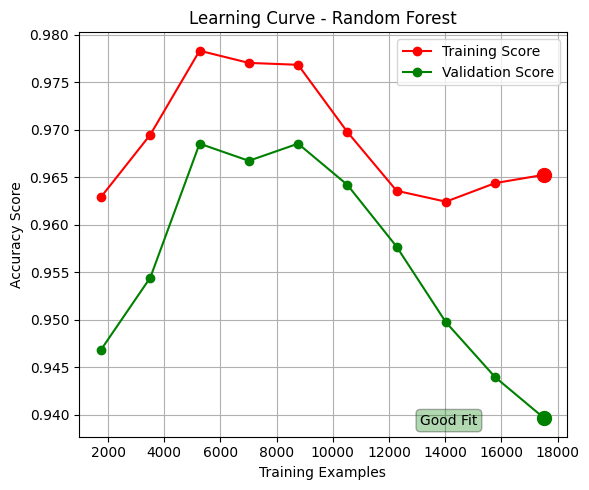

  - Final Training Score: 0.965
  - Final Validation Score: 0.940
  - Gap Training and Validation: 0.026
  - Model Assessment: Good Fit

=== Validation Set ===

📊 Validation Evaluation Results :
Accuracy (Validation): 0.94
F1-Score (Validation): 0.945
AUC (Validation): 0.974
AP (Validation): 0.86

📄 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      2504
           1       0.62      0.92      0.74       261

    accuracy                           0.94      2765
   macro avg       0.81      0.93      0.85      2765
weighted avg       0.96      0.94      0.94      2765



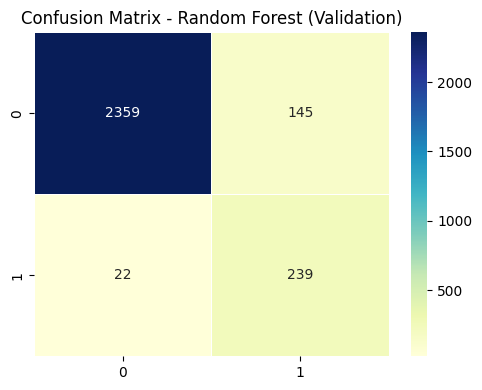

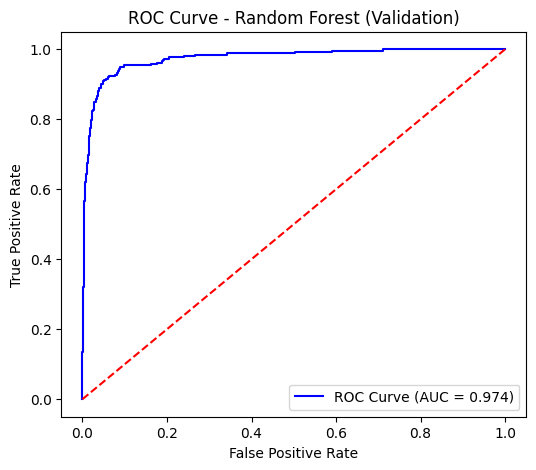

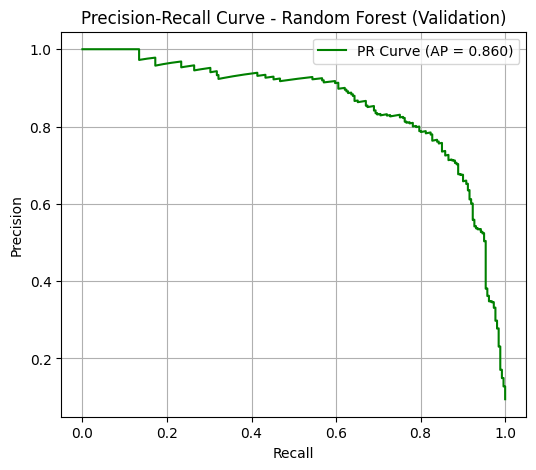


=== Test Set ===

📊 Test Evaluation Results :
Accuracy (Test): 0.936
F1-Score (Test): 0.941
AUC (Test): 0.964
AP (Test): 0.842

📄 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1253
           1       0.61      0.88      0.72       130

    accuracy                           0.94      1383
   macro avg       0.80      0.91      0.84      1383
weighted avg       0.95      0.94      0.94      1383



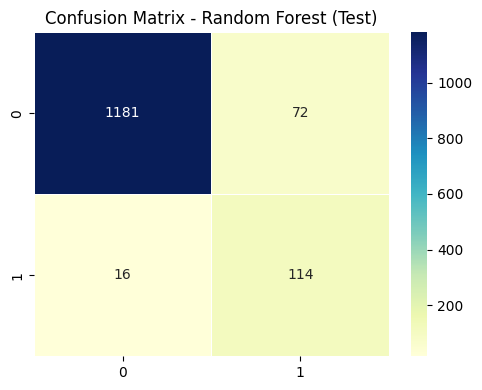

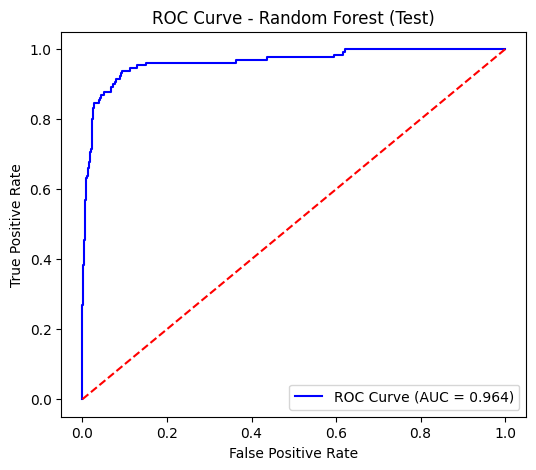

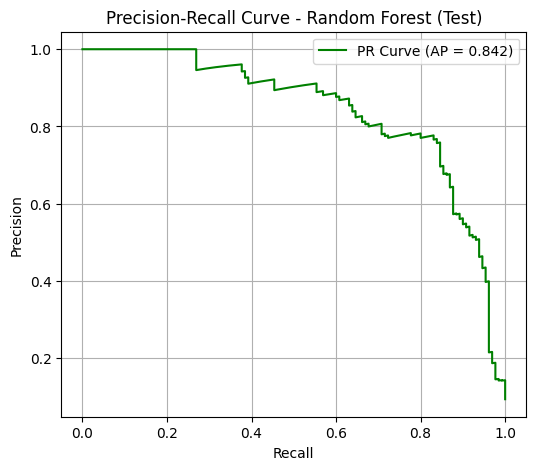


✅ Hasil evaluasi Random Forest disimpan di /content/drive/MyDrive/Data_Analytics/Result/Oversampling/Random Forest/


In [8]:
evaluator.evaluate("Random Forest")

## Decision Tree


=== Training Set ===

📊 Training Evaluation Results :


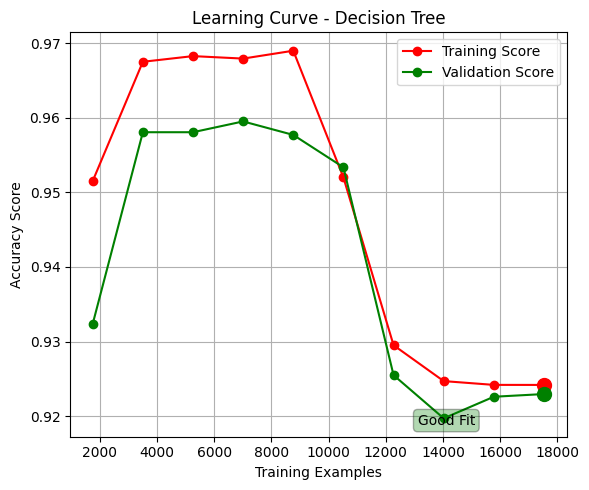

  - Final Training Score: 0.924
  - Final Validation Score: 0.923
  - Gap Training and Validation: 0.001
  - Model Assessment: Good Fit

=== Validation Set ===

📊 Validation Evaluation Results :
Accuracy (Validation): 0.923
F1-Score (Validation): 0.931
AUC (Validation): 0.959
AP (Validation): 0.723

📄 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2504
           1       0.56      0.90      0.69       261

    accuracy                           0.92      2765
   macro avg       0.77      0.91      0.82      2765
weighted avg       0.95      0.92      0.93      2765



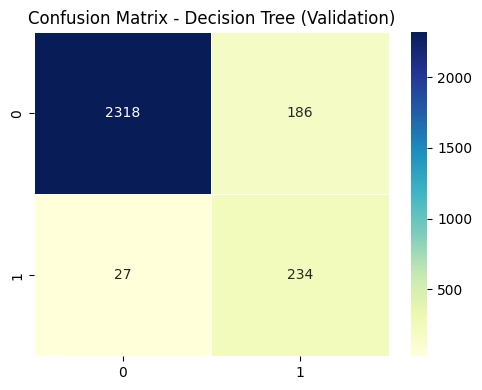

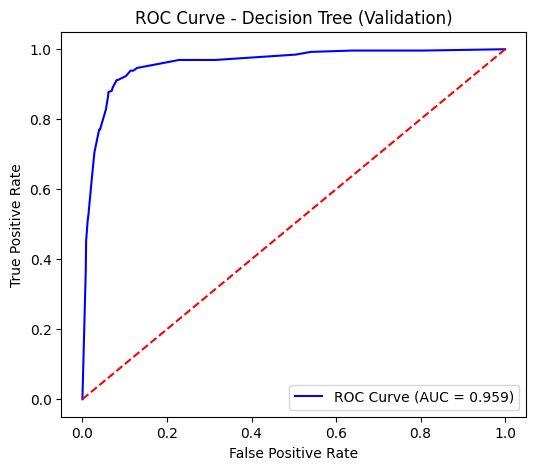

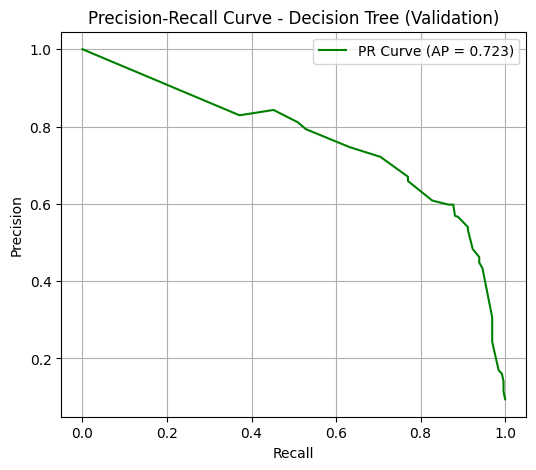


=== Test Set ===

📊 Test Evaluation Results :
Accuracy (Test): 0.922
F1-Score (Test): 0.929
AUC (Test): 0.95
AP (Test): 0.676

📄 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1253
           1       0.55      0.87      0.68       130

    accuracy                           0.92      1383
   macro avg       0.77      0.90      0.82      1383
weighted avg       0.95      0.92      0.93      1383



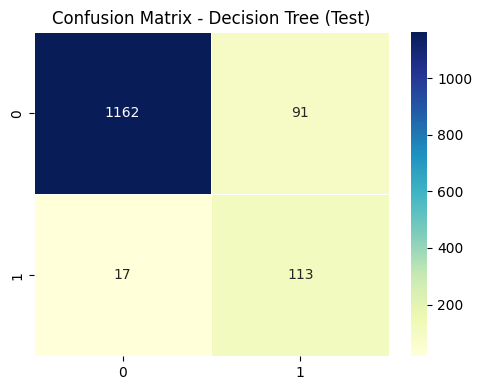

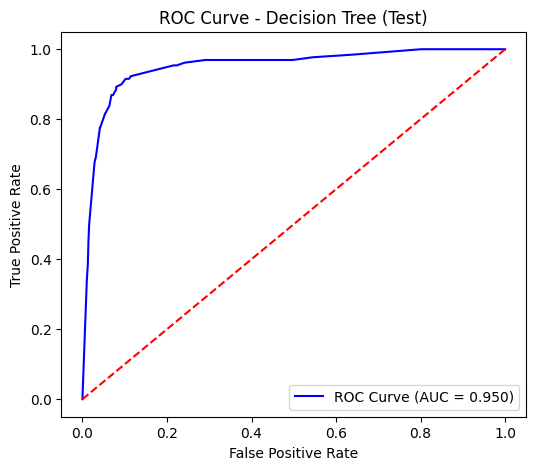

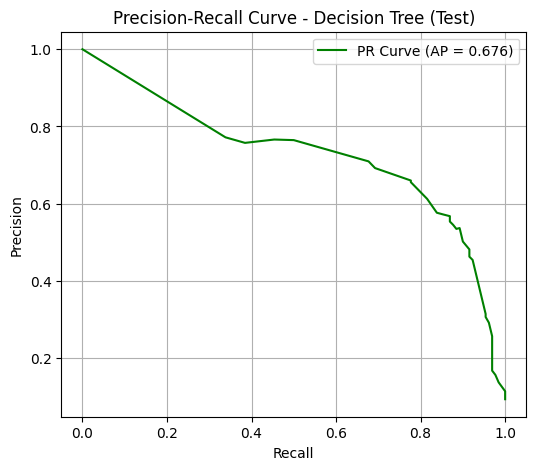


✅ Hasil evaluasi Decision Tree disimpan di /content/drive/MyDrive/Data_Analytics/Result/Oversampling/Decision Tree/


In [9]:
evaluator.evaluate("Decision Tree")

## XGBoost


=== Training Set ===

📊 Training Evaluation Results :


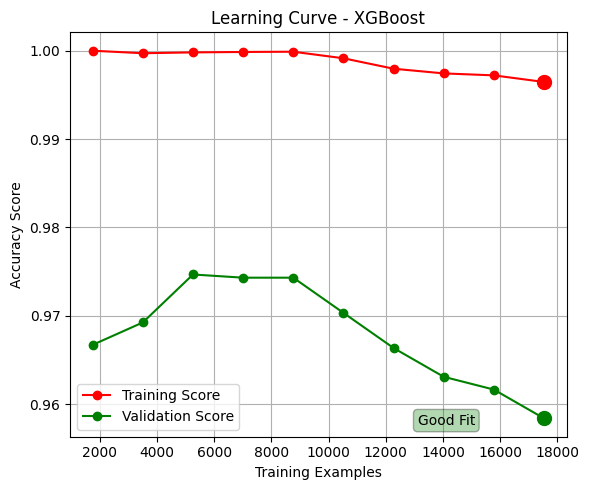

  - Final Training Score: 0.996
  - Final Validation Score: 0.958
  - Gap Training and Validation: 0.038
  - Model Assessment: Good Fit

=== Validation Set ===

📊 Validation Evaluation Results :
Accuracy (Validation): 0.958
F1-Score (Validation): 0.96
AUC (Validation): 0.979
AP (Validation): 0.909

📄 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2504
           1       0.73      0.89      0.80       261

    accuracy                           0.96      2765
   macro avg       0.86      0.93      0.89      2765
weighted avg       0.96      0.96      0.96      2765



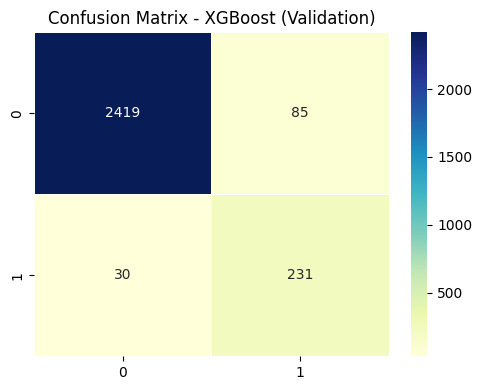

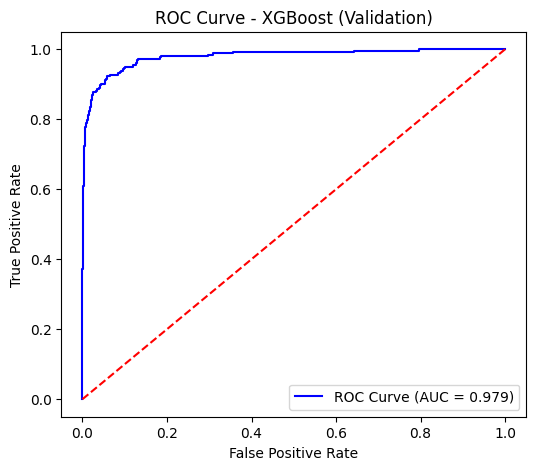

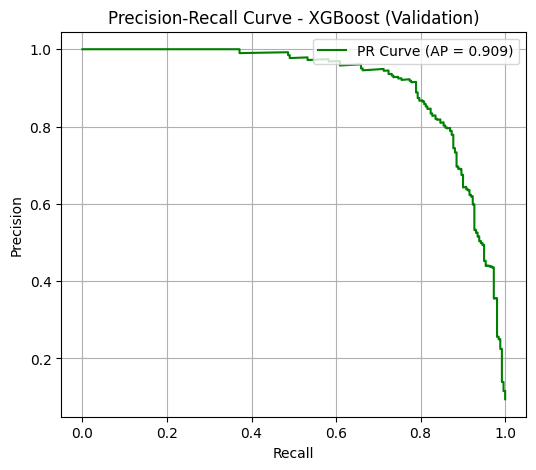


=== Test Set ===

📊 Test Evaluation Results :
Accuracy (Test): 0.954
F1-Score (Test): 0.956
AUC (Test): 0.965
AP (Test): 0.883

📄 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1253
           1       0.73      0.82      0.77       130

    accuracy                           0.95      1383
   macro avg       0.85      0.90      0.87      1383
weighted avg       0.96      0.95      0.96      1383



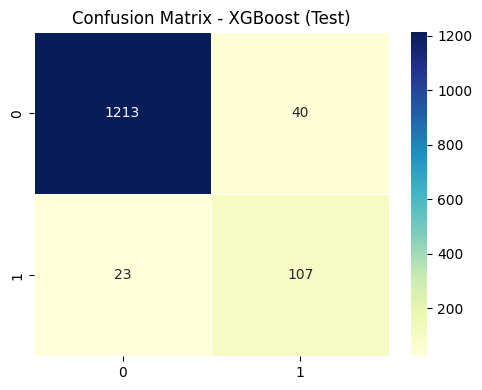

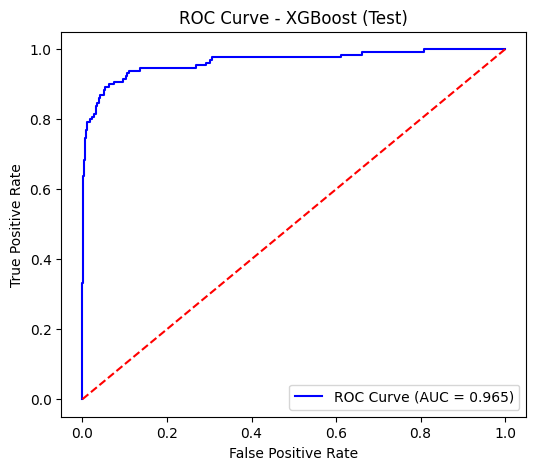

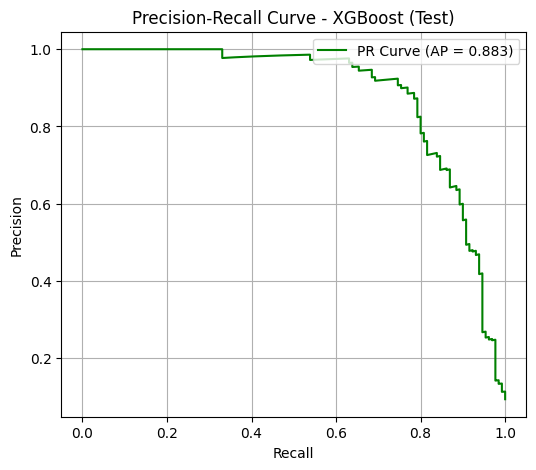


✅ Hasil evaluasi XGBoost disimpan di /content/drive/MyDrive/Data_Analytics/Result/Oversampling/XGBoost/


In [10]:
evaluator.evaluate("XGBoost")

## Gradient Boosting


=== Training Set ===

📊 Training Evaluation Results :


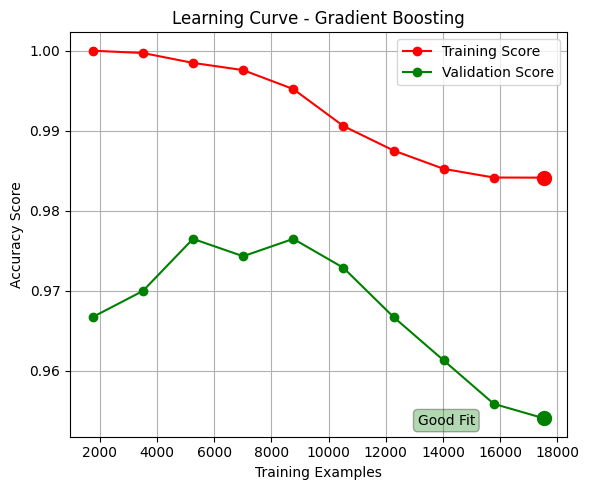

  - Final Training Score: 0.984
  - Final Validation Score: 0.954
  - Gap Training and Validation: 0.030
  - Model Assessment: Good Fit

=== Validation Set ===

📊 Validation Evaluation Results :
Accuracy (Validation): 0.954
F1-Score (Validation): 0.957
AUC (Validation): 0.98
AP (Validation): 0.906

📄 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2504
           1       0.70      0.90      0.79       261

    accuracy                           0.95      2765
   macro avg       0.84      0.93      0.88      2765
weighted avg       0.96      0.95      0.96      2765



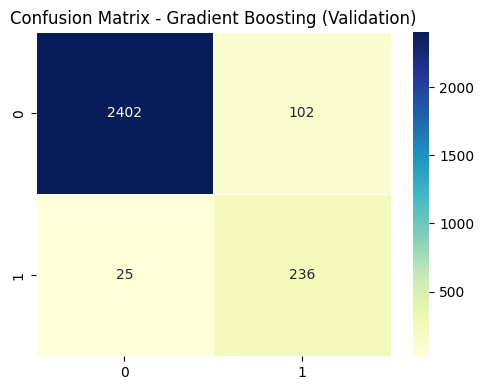

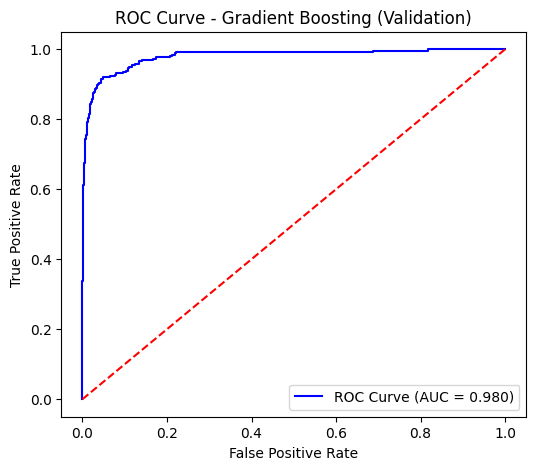

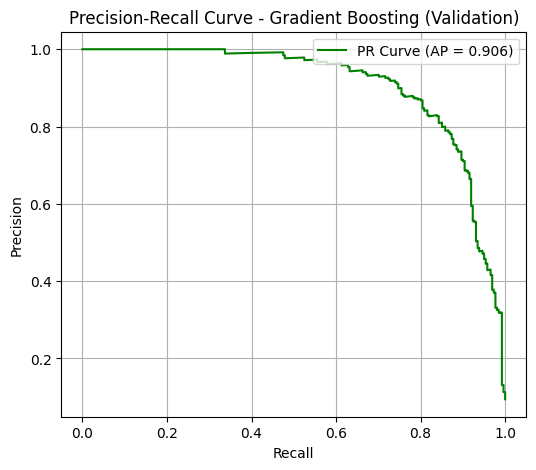


=== Test Set ===

📊 Test Evaluation Results :
Accuracy (Test): 0.952
F1-Score (Test): 0.954
AUC (Test): 0.964
AP (Test): 0.875

📄 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1253
           1       0.69      0.87      0.77       130

    accuracy                           0.95      1383
   macro avg       0.84      0.91      0.87      1383
weighted avg       0.96      0.95      0.95      1383



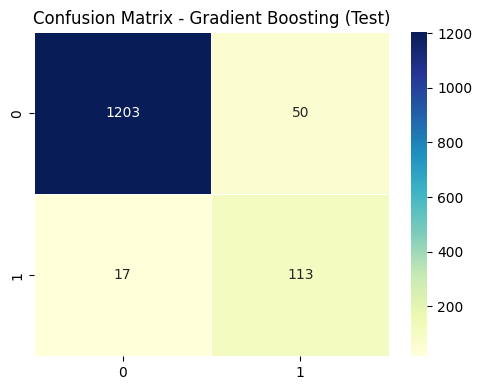

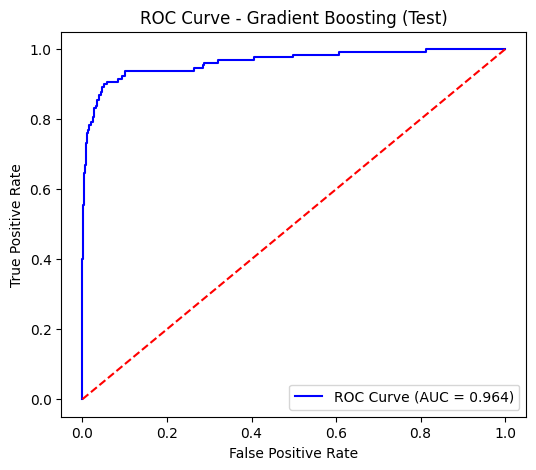

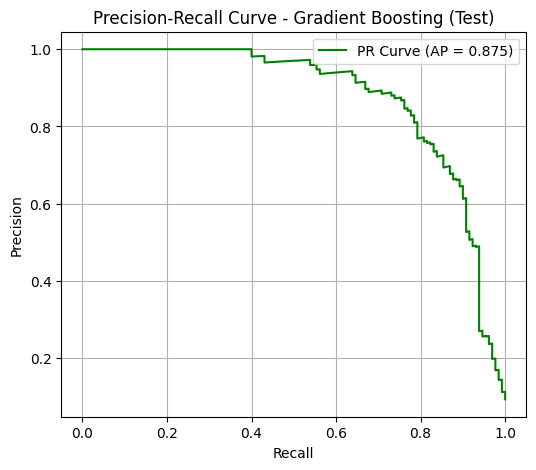


✅ Hasil evaluasi Gradient Boosting disimpan di /content/drive/MyDrive/Data_Analytics/Result/Oversampling/Gradient Boosting/


In [11]:
evaluator.evaluate("Gradient Boosting")

## CatBoost


=== Training Set ===

📊 Training Evaluation Results :


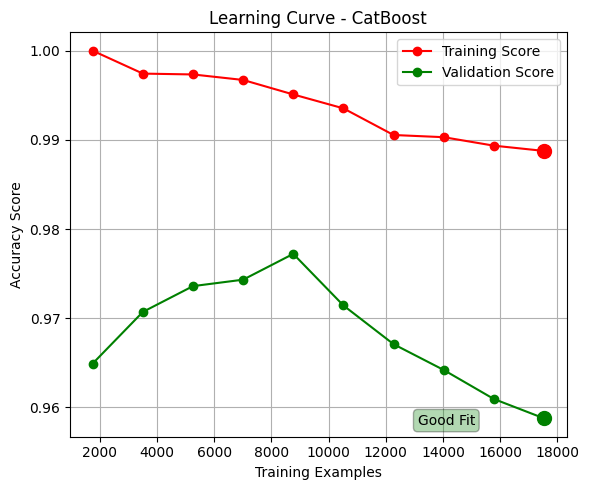

  - Final Training Score: 0.989
  - Final Validation Score: 0.959
  - Gap Training and Validation: 0.030
  - Model Assessment: Good Fit

=== Validation Set ===

📊 Validation Evaluation Results :
Accuracy (Validation): 0.959
F1-Score (Validation): 0.961
AUC (Validation): 0.982
AP (Validation): 0.911

📄 Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2504
           1       0.73      0.90      0.80       261

    accuracy                           0.96      2765
   macro avg       0.86      0.93      0.89      2765
weighted avg       0.96      0.96      0.96      2765



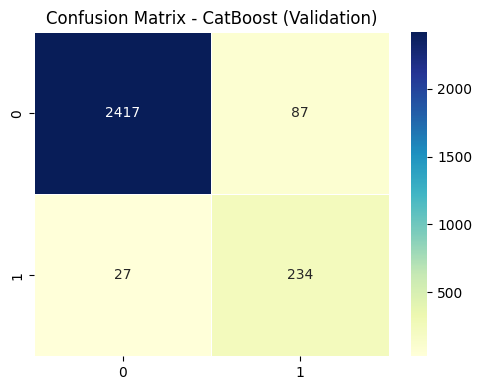

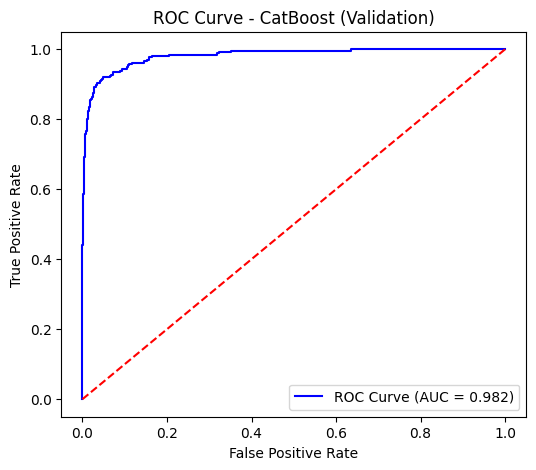

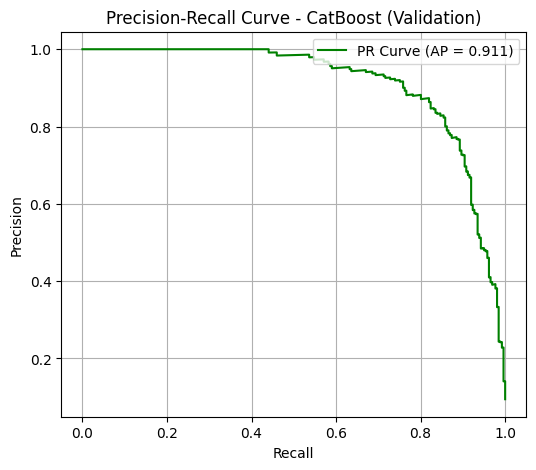


=== Test Set ===

📊 Test Evaluation Results :
Accuracy (Test): 0.953
F1-Score (Test): 0.955
AUC (Test): 0.965
AP (Test): 0.88

📄 Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1253
           1       0.70      0.86      0.78       130

    accuracy                           0.95      1383
   macro avg       0.84      0.91      0.87      1383
weighted avg       0.96      0.95      0.96      1383



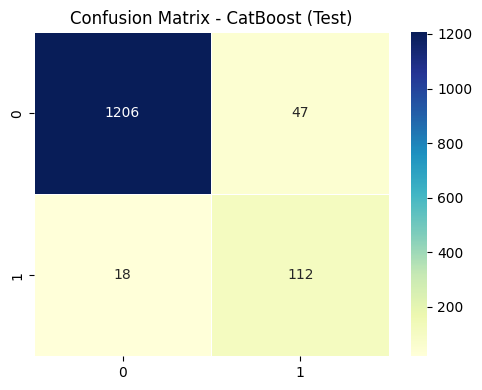

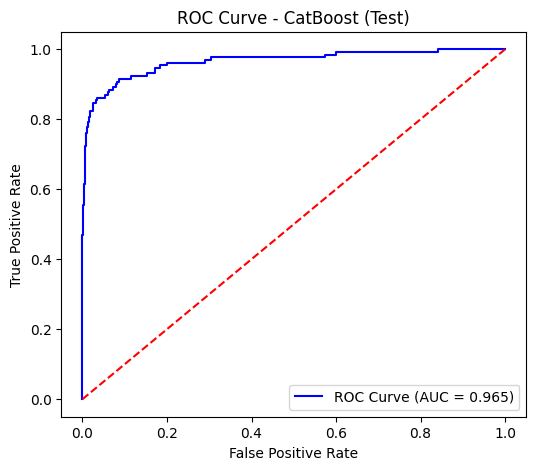

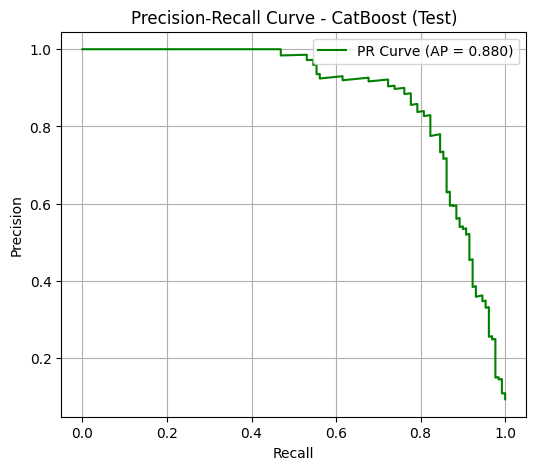


✅ Hasil evaluasi CatBoost disimpan di /content/drive/MyDrive/Data_Analytics/Result/Oversampling/CatBoost/


In [12]:
evaluator.evaluate("CatBoost")

## Compare All Model

In [13]:
model_names = ["Random Forest", "Decision Tree", "XGBoost", "Gradient Boosting", "CatBoost"]

evaluation_data = {
    "Accuracy (Training)": [],
    "Accuracy (Validation)": [],
    "F1-Score (Validation)": [],
    "AUC (Validation)": [],
    "AP (Validation)": [],
    "Accuracy (Test)": [],
    "F1-Score (Test)": [],
    "AUC (Test)": [],
    "AP (Test)": []
}

for model_name in model_names:
    json_path = os.path.join(result_path, model_name, f"{model_name}_evaluation.json")

    if os.path.exists(json_path):
        with open(json_path, "r") as file:
            eval_result = json.load(file)

        evaluation_data["Accuracy (Training)"].append(eval_result["Accuracy (Training)"])
        evaluation_data["Accuracy (Validation)"].append(eval_result["Accuracy (Validation)"])
        evaluation_data["F1-Score (Validation)"].append(eval_result["F1-Score (Validation)"])
        evaluation_data["AUC (Validation)"].append(eval_result["AUC (Validation)"])
        evaluation_data["Accuracy (Test)"].append(eval_result["Accuracy (Test)"])
        evaluation_data["F1-Score (Test)"].append(eval_result["F1-Score (Test)"])
        evaluation_data["AUC (Test)"].append(eval_result["AUC (Test)"])
        evaluation_data["AP (Validation)"].append(eval_result["AP (Validation)"])
        evaluation_data["AP (Test)"].append(eval_result["AP (Test)"])

df = pd.DataFrame(evaluation_data, index=model_names)

df["Final Score"] = df[[
    "F1-Score (Validation)",
    "AUC (Validation)",
    "AP (Validation)",
    "F1-Score (Test)",
    "AUC (Test)",
    "AP (Test)"
]].mean(axis=1)

df_sorted = df.sort_values(by="Final Score", ascending=False)
display(HTML(df_sorted.to_html()))

,Accuracy (Training),Accuracy (Validation),F1-Score (Validation),AUC (Validation),AP (Validation),Accuracy (Test),F1-Score (Test),AUC (Test),AP (Test),Final Score
CatBoost,0.989,0.959,0.961,0.982,0.911,0.953,0.955,0.965,0.880,0.942333
XGBoost,0.996,0.958,0.960,0.979,0.909,0.954,0.956,0.965,0.883,0.942000
Gradient Boosting,0.984,0.954,0.957,0.980,0.906,0.952,0.954,0.964,0.875,0.939333
Random Forest,0.965,0.940,0.945,0.974,0.860,0.936,0.941,0.964,0.842,0.921000
Decision Tree,0.924,0.923,0.931,0.959,0.723,0.922,0.929,0.950,0.676,0.861333


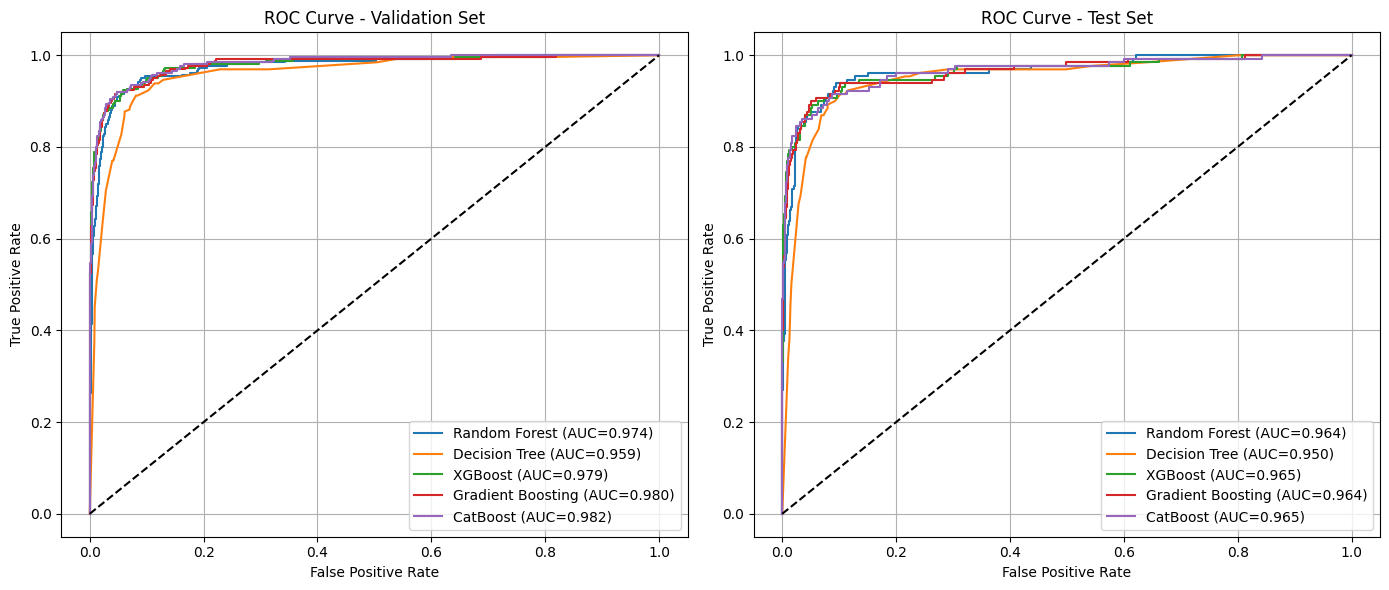

In [14]:
evaluator.plot_roc_side_by_side()

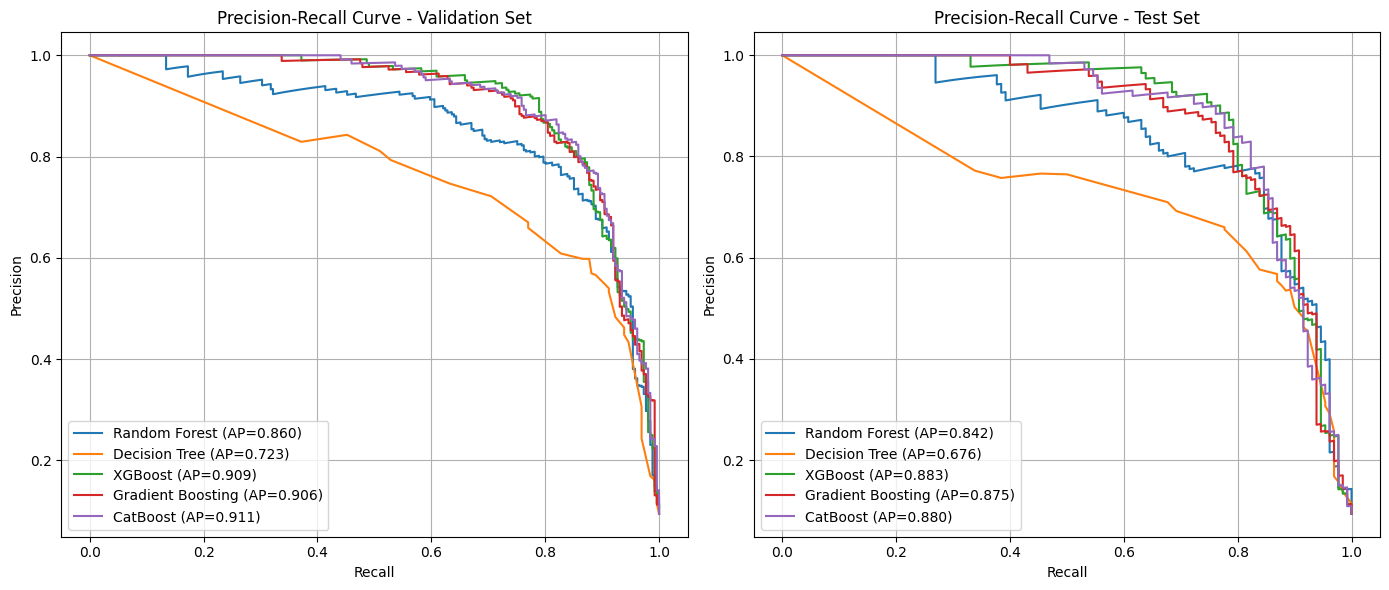

In [15]:
evaluator.plot_pr_side_by_side()